In [1]:
import numpy as np
import keras
from keras import backend as k
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_path = 'cats-dogs-monkeys-cows/train'
valid_path = 'cats-dogs-monkeys-cows/valid'
test_path = 'cats-dogs-monkeys-cows/test'

In [3]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dog','cat','monkey','cow'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['dog','cat','monkey','cow'], batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['dog','cat','monkey','cow'], batch_size=4)

Found 40 images belonging to 4 classes.
Found 16 images belonging to 4 classes.
Found 16 images belonging to 4 classes.


In [4]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [5]:
imgs, labels = next(train_batches)

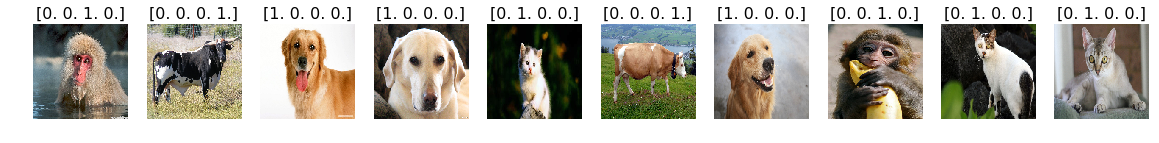

In [6]:
plots(imgs, titles=labels)

In [7]:
train_batches.class_indices

{'cat': 1, 'cow': 3, 'dog': 0, 'monkey': 2}

In [8]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
vgg16_model = keras.applications.vgg16.VGG16()

In [10]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [11]:
type(vgg16_model)

keras.engine.training.Model

In [12]:
model = Sequential()
for i in vgg16_model.layers:
    model.add(i)

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [14]:
model.layers.pop()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [15]:
for layer in model.layers:
    layer.trainable = False

In [16]:
model.add(Dense(4, activation='softmax'))

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [18]:
model.compile(Adam(lr=0.07), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit_generator(train_batches, steps_per_epoch=1, 
                    validation_data=valid_batches, validation_steps=1, epochs=30, verbose=2)

Epoch 1/30
 - 17s - loss: 1.3946 - acc: 0.3000 - val_loss: 1.3097 - val_acc: 0.5000
Epoch 2/30
 - 2s - loss: 1.3217 - acc: 0.6000 - val_loss: 1.2513 - val_acc: 0.7500
Epoch 3/30
 - 2s - loss: 1.2892 - acc: 0.5000 - val_loss: 1.1851 - val_acc: 1.0000
Epoch 4/30
 - 2s - loss: 1.2114 - acc: 0.9000 - val_loss: 1.1184 - val_acc: 1.0000
Epoch 5/30
 - 2s - loss: 1.1545 - acc: 0.9000 - val_loss: 1.0536 - val_acc: 1.0000
Epoch 6/30
 - 2s - loss: 1.0859 - acc: 1.0000 - val_loss: 0.9937 - val_acc: 1.0000
Epoch 7/30
 - 2s - loss: 1.0216 - acc: 1.0000 - val_loss: 0.9325 - val_acc: 1.0000
Epoch 8/30
 - 2s - loss: 0.9336 - acc: 1.0000 - val_loss: 0.8745 - val_acc: 1.0000
Epoch 9/30
 - 2s - loss: 0.9035 - acc: 1.0000 - val_loss: 0.8207 - val_acc: 1.0000
Epoch 10/30
 - 2s - loss: 0.7910 - acc: 1.0000 - val_loss: 0.7682 - val_acc: 1.0000
Epoch 11/30
 - 2s - loss: 0.8085 - acc: 1.0000 - val_loss: 0.7217 - val_acc: 1.0000
Epoch 12/30
 - 2s - loss: 0.7676 - acc: 1.0000 - val_loss: 0.6749 - val_acc: 1.0000


In [20]:
model.save_weights('model_weights.h5')

[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
[[0.05355249 0.84613526 0.05407411 0.0462381 ]
 [0.4054818  0.3584248  0.10857169 0.12752165]
 [0.05802601 0.05583945 0.8392514  0.04688307]
 [0.07335009 0.07634586 0.7925684  0.05773568]]


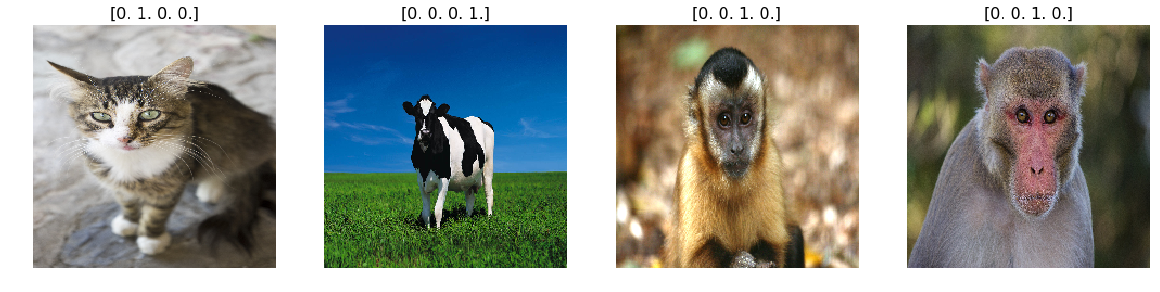

In [21]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)
print(test_labels)
predictions = model.predict_on_batch(np.array(test_imgs))
print(predictions)
test_labels = np.array(test_labels.argmax(axis=1))
predictions = np.array(predictions.argmax(axis=1))

In [22]:
print(test_labels)
print(predictions)

[1 3 2 2]
[1 0 2 2]


In [23]:
cm = confusion_matrix(test_labels, predictions)

In [24]:
cm_plot_labels = ['cat','dog','monkey','cow']
if 0 not in test_labels and 0 not in predictions:
    cm_plot_labels.remove('dog')
if 1 not in test_labels and 1 not in predictions:
    cm_plot_labels.remove('cat')
if 2 not in test_labels and 2 not in predictions:
    cm_plot_labels.remove('monkey')
if 3 not in test_labels and 3 not in predictions:
    cm_plot_labels.remove('cow')

Confusion matrix, without normalization
[[0 0 0 0]
 [0 1 0 0]
 [0 0 2 0]
 [1 0 0 0]]


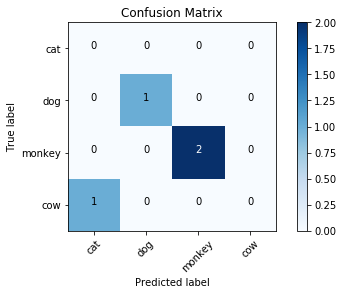

In [25]:
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')